<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/ConvNeXT_adapter_mni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
!pip install numpy==1.24.3

In [ ]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/custom_models/swin_UNETR_mod4_ConvNeXt.py .

In [ ]:
from swin_UNETR_mod4_ConvNeXt import SwinUNETR

In [ ]:
import pandas as pd

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
#from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.24.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.50.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

##Image, Label and FreeSurferColorLUT Directory

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
image_dir = "MNI_train_data/image_files"
label_dir = "MNI_train_data/label_files_combined"

In [ ]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
len(images), len(labels)

(25, 25)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




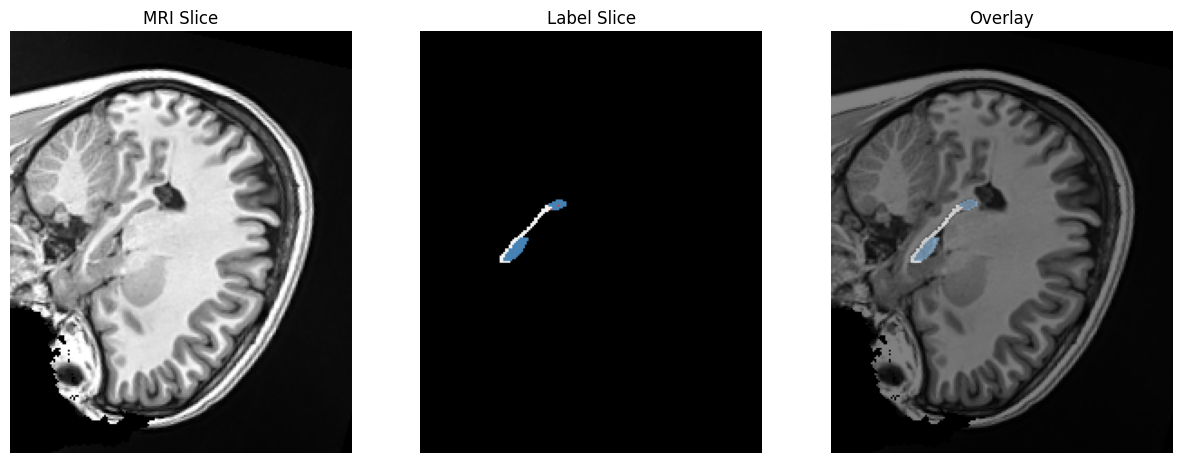

In [ ]:
visualize_image(images[0],labels[0], 75)

##Image Transforms and Custom Dataset

####Transforms

In [ ]:
from monai.transforms import SpatialCrop, CenterSpatialCrop

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:20]
val_files   = data_dicts[20:]


In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
imgt, segt = train_ds[0]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((160, 160, 160), (160, 160, 160))

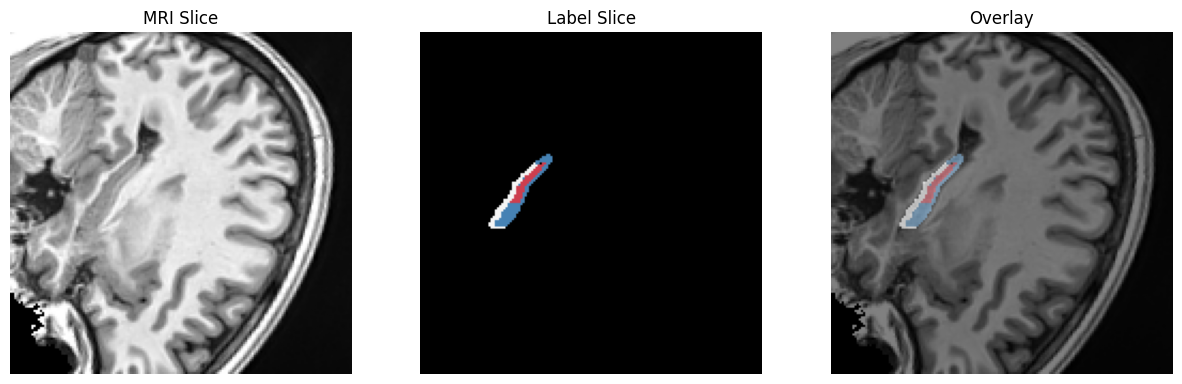

In [ ]:
visualize_image(imgt, segt, 50, array = True)

##Model, Optimizer and Loss Function

In [ ]:
from monai.losses import DiceCELoss

In [ ]:
set_determinism(seed=40)

num_classes = 4

model = SwinUNETR(
    img_size=(160, 160, 160),
    in_channels=1,
    out_channels=num_classes,
    feature_size=24,
    use_checkpoint=True

).cuda()


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: swin_UNETR_mod4_ConvNeXt SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Loading Pre-Trained Model

In [ ]:
len(model.state_dict())

239

In [ ]:
pretrained_dict = torch.load('160_24fs_lr-3_best_dice_model.pth')
model_dict = model.state_dict()

# Count total parameters in both models
total_pretrained_params = len(pretrained_dict)
total_current_params = len(model_dict)

# Check which parameters match in name
name_matches = [k for k in pretrained_dict.keys() if k in model_dict]
print(f"Parameters matching by name: {len(name_matches)} out of {total_pretrained_params}")

# Check which parameters match in both name and shape
filtered_dict = {
    k: v
    for k, v in pretrained_dict.items()
    if k in model_dict and model_dict[k].shape == v.shape
}

# Print statistics
print(f"Parameters matching by name and shape: {len(filtered_dict)} out of {total_pretrained_params}")
print(f"Parameters that will NOT be updated: {total_current_params - len(filtered_dict)} out of {total_current_params}")

# Print the specific layers that will NOT be updated
non_updated_layers = [k for k in model_dict.keys() if k not in filtered_dict]
print("\nLayers that will NOT be updated:")
for layer in non_updated_layers:
    print(f"- {layer} with shape {model_dict[layer].shape}")

# Update and load as before
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
print("\nModel successfully updated!")

Parameters matching by name: 159 out of 159
Parameters matching by name and shape: 157 out of 159
Parameters that will NOT be updated: 82 out of 239

Layers that will NOT be updated:
- swinViT.layers1.0.adapters.depthwise.weight with shape torch.Size([24, 1, 3, 3, 3])
- swinViT.layers1.0.adapters.depthwise.bias with shape torch.Size([24])
- swinViT.layers1.0.adapters.expansion_conv.weight with shape torch.Size([96, 24, 1, 1, 1])
- swinViT.layers1.0.adapters.expansion_conv.bias with shape torch.Size([96])
- swinViT.layers1.0.adapters.pointwise.weight with shape torch.Size([24, 96, 1, 1, 1])
- swinViT.layers1.0.adapters.pointwise.bias with shape torch.Size([24])
- swinViT.layers1.0.adapters.layer_norm.weight with shape torch.Size([24])
- swinViT.layers1.0.adapters.layer_norm.bias with shape torch.Size([24])
- swinViT.layers2.0.adapters.depthwise.weight with shape torch.Size([48, 1, 3, 3, 3])
- swinViT.layers2.0.adapters.depthwise.bias with shape torch.Size([48])
- swinViT.layers2.0.adapt

#Adapter Layer

##Freezing Encoder Layers

In [ ]:
for name, param in model.named_parameters():
  param.requires_grad = False

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

swinViT.patch_embed.proj.weight: Frozen
swinViT.patch_embed.proj.bias: Frozen
swinViT.layers1.0.blocks.0.norm1.weight: Frozen
swinViT.layers1.0.blocks.0.norm1.bias: Frozen
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table: Frozen
swinViT.layers1.0.blocks.0.attn.qkv.weight: Frozen
swinViT.layers1.0.blocks.0.attn.qkv.bias: Frozen
swinViT.layers1.0.blocks.0.attn.proj.weight: Frozen
swinViT.layers1.0.blocks.0.attn.proj.bias: Frozen
swinViT.layers1.0.blocks.0.norm2.weight: Frozen
swinViT.layers1.0.blocks.0.norm2.bias: Frozen
swinViT.layers1.0.blocks.0.mlp.linear1.weight: Frozen
swinViT.layers1.0.blocks.0.mlp.linear1.bias: Frozen
swinViT.layers1.0.blocks.0.mlp.linear2.weight: Frozen
swinViT.layers1.0.blocks.0.mlp.linear2.bias: Frozen
swinViT.layers1.0.blocks.1.norm1.weight: Frozen
swinViT.layers1.0.blocks.1.norm1.bias: Frozen
swinViT.layers1.0.blocks.1.attn.relative_position_bias_table: Frozen
swinViT.layers1.0.blocks.1.attn.qkv.weight: Frozen
swinViT.layers1.0.blocks.1.attn.qkv.b

In [ ]:
for name, param in model.named_parameters():
    if ("adapters" in name or "out" in name or "decoder1" in name or "encoder1." in name):
        param.requires_grad = True

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


swinViT.patch_embed.proj.weight: Frozen
swinViT.patch_embed.proj.bias: Frozen
swinViT.layers1.0.blocks.0.norm1.weight: Frozen
swinViT.layers1.0.blocks.0.norm1.bias: Frozen
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table: Frozen
swinViT.layers1.0.blocks.0.attn.qkv.weight: Frozen
swinViT.layers1.0.blocks.0.attn.qkv.bias: Frozen
swinViT.layers1.0.blocks.0.attn.proj.weight: Frozen
swinViT.layers1.0.blocks.0.attn.proj.bias: Frozen
swinViT.layers1.0.blocks.0.norm2.weight: Frozen
swinViT.layers1.0.blocks.0.norm2.bias: Frozen
swinViT.layers1.0.blocks.0.mlp.linear1.weight: Frozen
swinViT.layers1.0.blocks.0.mlp.linear1.bias: Frozen
swinViT.layers1.0.blocks.0.mlp.linear2.weight: Frozen
swinViT.layers1.0.blocks.0.mlp.linear2.bias: Frozen
swinViT.layers1.0.blocks.1.norm1.weight: Frozen
swinViT.layers1.0.blocks.1.norm1.bias: Frozen
swinViT.layers1.0.blocks.1.attn.relative_position_bias_table: Frozen
swinViT.layers1.0.blocks.1.attn.qkv.weight: Frozen
swinViT.layers1.0.blocks.1.attn.qkv.b

In [ ]:
# Calculate total, trainable, and non-trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print("Total parameters:", total_params)
print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)

Total parameters: 17710150
Trainable parameters: 2075836
Non-trainable parameters: 15634314


##Model Details

In [ ]:

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, include_background=True)

trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True, to_onehot=num_classes)
])


In [ ]:
#summary(model, input_size=(1, 1, 128, 128, 128))

In [ ]:
'''
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")
'''

'\ninput_tensor = torch.randn(1, 1, 128, 128, 128)\nflops, params = profile(model, inputs=(input_tensor,))\nprint(f"FLOPs: {flops}")\nprint(f"Parameters: {params}")\n'

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [ ]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('adapter3_conv_adpat_Checkpoint.pth')

##Epochs and Validation

In [ ]:
max_epochs = 80
val_interval = 1

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
checkpoint_path = 'Train_Data_INFO/adapter7_mednext_Checkpoint.pth'
best_model_path = 'Train_Data_INFO/adapter7_mednext_best_dice_model.pth'

#Training Loop
for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")

    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")

Epoch [1/80] 2025-04-11 07:17:39.712652


  Train loss: 0.7104


  Validation Dice: 0.2497
   Saved new best model
Epoch [2/80] 2025-04-11 07:18:19.172776


  Train loss: 0.5363


  Validation Dice: 0.2497
Epoch [3/80] 2025-04-11 07:18:58.004840


  Train loss: 0.4913


  Validation Dice: 0.5215
   Saved new best model
Epoch [4/80] 2025-04-11 07:19:37.262281


  Train loss: 0.3070


  Validation Dice: 0.6882
   Saved new best model
Epoch [5/80] 2025-04-11 07:20:17.459162


  Train loss: 0.2105


  Validation Dice: 0.7430
   Saved new best model
Epoch [6/80] 2025-04-11 07:20:57.477371


  Train loss: 0.1807


  Validation Dice: 0.7635
   Saved new best model
Epoch [7/80] 2025-04-11 07:21:37.159258


  Train loss: 0.1654


  Validation Dice: 0.7500
Epoch [8/80] 2025-04-11 07:22:16.588971


  Train loss: 0.1612


  Validation Dice: 0.7684
   Saved new best model
Epoch [9/80] 2025-04-11 07:22:56.344746


  Train loss: 0.1488


  Validation Dice: 0.7892
   Saved new best model
Epoch [10/80] 2025-04-11 07:23:36.172266


  Train loss: 0.1403


  Validation Dice: 0.7932
   Saved new best model
Epoch [11/80] 2025-04-11 07:24:15.982971


  Train loss: 0.1305


  Validation Dice: 0.7811
Epoch [12/80] 2025-04-11 07:24:55.559321


  Train loss: 0.1265


  Validation Dice: 0.8066
   Saved new best model
Epoch [13/80] 2025-04-11 07:25:35.694299


  Train loss: 0.1216


  Validation Dice: 0.8105
   Saved new best model
Epoch [14/80] 2025-04-11 07:26:15.533192


  Train loss: 0.1134


  Validation Dice: 0.8057
Epoch [15/80] 2025-04-11 07:26:55.698229


  Train loss: 0.1145


  Validation Dice: 0.8094
Epoch [16/80] 2025-04-11 07:27:35.326477


  Train loss: 0.1109


  Validation Dice: 0.8173
   Saved new best model
Epoch [17/80] 2025-04-11 07:28:15.172116


  Train loss: 0.1056


  Validation Dice: 0.8081
Epoch [18/80] 2025-04-11 07:28:54.705018


  Train loss: 0.1028


  Validation Dice: 0.8189
   Saved new best model
Epoch [19/80] 2025-04-11 07:29:34.633967


  Train loss: 0.1006


  Validation Dice: 0.8131
Epoch [20/80] 2025-04-11 07:30:14.243598


  Train loss: 0.0951


  Validation Dice: 0.8242
   Saved new best model
Epoch [21/80] 2025-04-11 07:30:54.350859


  Train loss: 0.0936


  Validation Dice: 0.8255
   Saved new best model
Epoch [22/80] 2025-04-11 07:31:34.151974


  Train loss: 0.0925


  Validation Dice: 0.8164
Epoch [23/80] 2025-04-11 07:32:14.241863


  Train loss: 0.0909


  Validation Dice: 0.8049
Epoch [24/80] 2025-04-11 07:32:53.857293


  Train loss: 0.0953


  Validation Dice: 0.8159
Epoch [25/80] 2025-04-11 07:33:33.463097


  Train loss: 0.0910


  Validation Dice: 0.8275
   Saved new best model
Epoch [26/80] 2025-04-11 07:34:13.296125


  Train loss: 0.0849


  Validation Dice: 0.8150
Epoch [27/80] 2025-04-11 07:34:53.675218


  Train loss: 0.0844


  Validation Dice: 0.8198
Epoch [28/80] 2025-04-11 07:35:33.266641


  Train loss: 0.0818


  Validation Dice: 0.8198
Epoch [29/80] 2025-04-11 07:36:12.790277


  Train loss: 0.0794


  Validation Dice: 0.8248
Epoch [30/80] 2025-04-11 07:36:52.617507


  Train loss: 0.0786


  Validation Dice: 0.8189
Epoch [31/80] 2025-04-11 07:37:32.179215


  Train loss: 0.0787


  Validation Dice: 0.8164
Epoch [32/80] 2025-04-11 07:38:11.735458


  Train loss: 0.0767


  Validation Dice: 0.8302
   Saved new best model
Epoch [33/80] 2025-04-11 07:38:51.640850


  Train loss: 0.0784


  Validation Dice: 0.8173
Epoch [34/80] 2025-04-11 07:39:31.189047


  Train loss: 0.0748


  Validation Dice: 0.8301
Epoch [35/80] 2025-04-11 07:40:10.836775


  Train loss: 0.0729


  Validation Dice: 0.8291
Epoch [36/80] 2025-04-11 07:40:50.644249


  Train loss: 0.0701


  Validation Dice: 0.8200
Epoch [37/80] 2025-04-11 07:41:30.302454


  Train loss: 0.0711


  Validation Dice: 0.8219
Epoch [38/80] 2025-04-11 07:42:09.868246


  Train loss: 0.0695


  Validation Dice: 0.8237
Epoch [39/80] 2025-04-11 07:42:49.424038


  Train loss: 0.0695


  Validation Dice: 0.8105
Epoch [40/80] 2025-04-11 07:43:28.984069


  Train loss: 0.0710


  Validation Dice: 0.8235
Epoch [41/80] 2025-04-11 07:44:08.515382


  Train loss: 0.0735


  Validation Dice: 0.8040
Epoch [42/80] 2025-04-11 07:44:48.043450


  Train loss: 0.0708


  Validation Dice: 0.8206
Epoch [43/80] 2025-04-11 07:45:27.617548


  Train loss: 0.0716


  Validation Dice: 0.8312
   Saved new best model
Epoch [44/80] 2025-04-11 07:46:07.495367


  Train loss: 0.0692


  Validation Dice: 0.8276
Epoch [45/80] 2025-04-11 07:46:47.179999


  Train loss: 0.0686


  Validation Dice: 0.8301
Epoch [46/80] 2025-04-11 07:47:26.857164


  Train loss: 0.0656


  Validation Dice: 0.8244
Epoch [47/80] 2025-04-11 07:48:06.495265


  Train loss: 0.0640


  Validation Dice: 0.8332
   Saved new best model
Epoch [48/80] 2025-04-11 07:48:46.822645


  Train loss: 0.0628


  Validation Dice: 0.8329
Epoch [49/80] 2025-04-11 07:49:26.355687


  Train loss: 0.0610


  Validation Dice: 0.8280
Epoch [50/80] 2025-04-11 07:50:05.921110


  Train loss: 0.0583


  Validation Dice: 0.8305
Epoch [51/80] 2025-04-11 07:50:45.531361


  Train loss: 0.0570


  Validation Dice: 0.8256
Epoch [52/80] 2025-04-11 07:51:25.099290


  Train loss: 0.0594


  Validation Dice: 0.8247
Epoch [53/80] 2025-04-11 07:52:04.708785


  Train loss: 0.0596


  Validation Dice: 0.8200
Epoch [54/80] 2025-04-11 07:52:44.594612


  Train loss: 0.0573


  Validation Dice: 0.8277
Epoch [55/80] 2025-04-11 07:53:24.146037


  Train loss: 0.0570


  Validation Dice: 0.8293
Epoch [56/80] 2025-04-11 07:54:03.835746


  Train loss: 0.0586


  Validation Dice: 0.8275
Epoch [57/80] 2025-04-11 07:54:43.428941


  Train loss: 0.0581


  Validation Dice: 0.8254
Epoch [58/80] 2025-04-11 07:55:22.912309


  Train loss: 0.0599


  Validation Dice: 0.8209
Epoch [59/80] 2025-04-11 07:56:02.794117


  Train loss: 0.0590


  Validation Dice: 0.8347
   Saved new best model
Epoch [60/80] 2025-04-11 07:56:42.632179


  Train loss: 0.0571


  Validation Dice: 0.8293
Epoch [61/80] 2025-04-11 07:57:22.184505


  Train loss: 0.0567


  Validation Dice: 0.8316
Epoch [62/80] 2025-04-11 07:58:01.695678


  Train loss: 0.0561


  Validation Dice: 0.8297
Epoch [63/80] 2025-04-11 07:58:41.197716


  Train loss: 0.0551


  Validation Dice: 0.8273
Epoch [64/80] 2025-04-11 07:59:20.733171


  Train loss: 0.0547


  Validation Dice: 0.8287
Epoch [65/80] 2025-04-11 08:00:00.285144


  Train loss: 0.0550


  Validation Dice: 0.8277
Epoch [66/80] 2025-04-11 08:00:39.846605


  Train loss: 0.0555


  Validation Dice: 0.8260
Epoch [67/80] 2025-04-11 08:01:19.362809


  Train loss: 0.0550


  Validation Dice: 0.8287
Epoch [68/80] 2025-04-11 08:01:58.919450


  Train loss: 0.0516


  Validation Dice: 0.8292
Epoch [69/80] 2025-04-11 08:02:38.475628


  Train loss: 0.0517


  Validation Dice: 0.8217
Epoch [70/80] 2025-04-11 08:03:18.312748


  Train loss: 0.0559


  Validation Dice: 0.8262
Epoch [71/80] 2025-04-11 08:03:58.128911


  Train loss: 0.0582


  Validation Dice: 0.8237
Epoch [72/80] 2025-04-11 08:04:37.694096


  Train loss: 0.0558


  Validation Dice: 0.8294
Epoch [73/80] 2025-04-11 08:05:17.280323


  Train loss: 0.0519


  Validation Dice: 0.8325
Epoch [74/80] 2025-04-11 08:05:56.791941


  Train loss: 0.0507


  Validation Dice: 0.8340
Epoch [75/80] 2025-04-11 08:06:36.377320


  Train loss: 0.0496


  Validation Dice: 0.8300
Epoch [76/80] 2025-04-11 08:07:16.184076


  Train loss: 0.0502


  Validation Dice: 0.8287
Epoch [77/80] 2025-04-11 08:07:55.787138


  Train loss: 0.0506


  Validation Dice: 0.8236
Epoch [78/80] 2025-04-11 08:08:35.359821


  Train loss: 0.0507


  Validation Dice: 0.8269
Epoch [79/80] 2025-04-11 08:09:14.967800


  Train loss: 0.0504


  Validation Dice: 0.8334
Epoch [80/80] 2025-04-11 08:09:54.527154


  Train loss: 0.0511


  Validation Dice: 0.8110

Training complete. Best val Dice: 0.8347 at epoch 59


##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(80, 80, 80)

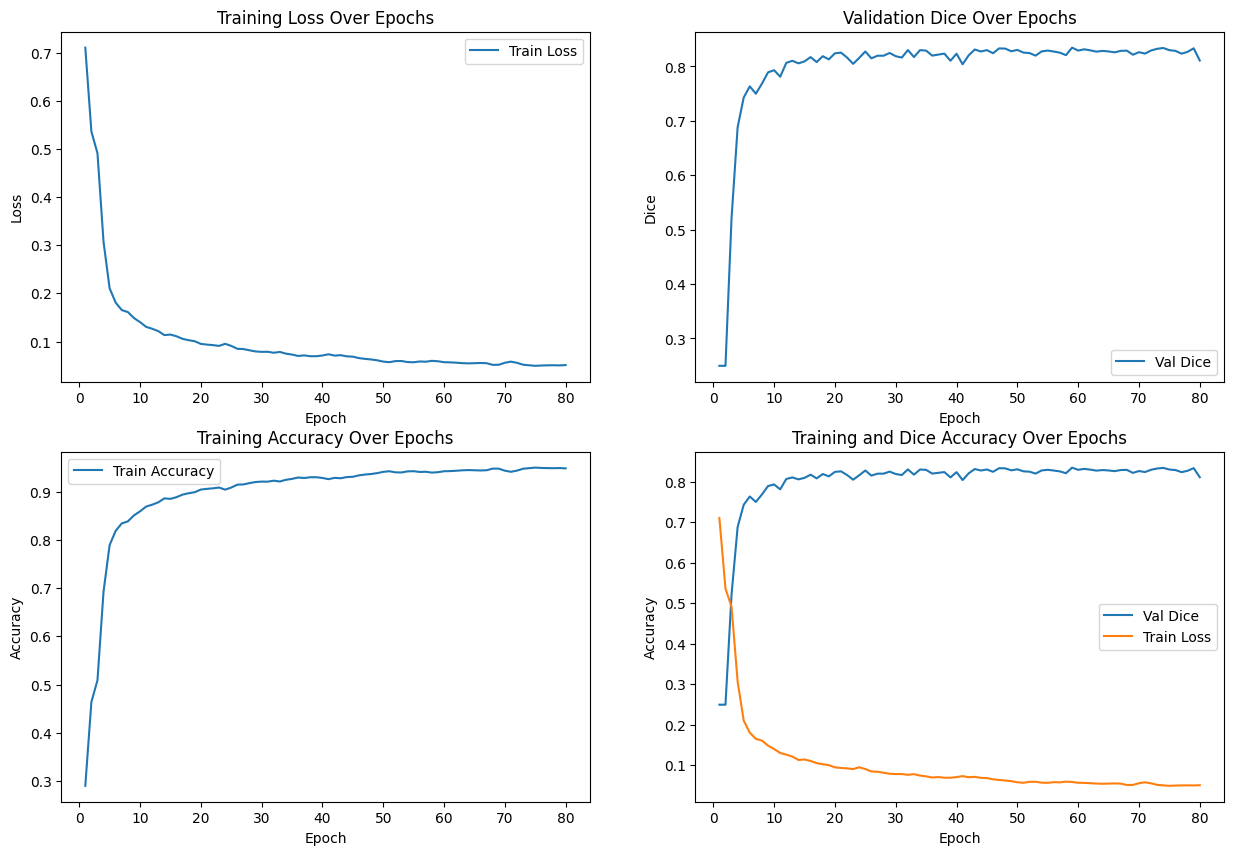

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()

axs[1, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[1, 1].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_title("Training and Dice Accuracy Over Epochs")
axs[1, 1].legend()

plt.show()

In [ ]:
df = pd.DataFrame({'Max_Epoch': epoch,
                     "Epoch_list": epoch_list,
                     "Validation_List": val_dice_list,
                     "Train_Loss_List": train_loss_list,
                     "Best_Dice": best_metric,
                     "Best_Dice_Epoch": best_metric_epoch})

file_path = "Train_Data_INFO/adapter7_convneXt_info.csv"

df.to_csv(file_path, index=False)
print(f"File saved to: {os.path.abspath(file_path)}")

File saved to: /content/drive/MyDrive/Train_Data_INFO/adapter7_convneXt_info.csv


##Model Evaluation

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

def dice_score(pred, target, num_classes):
    """
    Calculate Dice score for each class and the combined hippocampus structure.

    Args:
        pred (torch.Tensor): Predicted class indices, shape [batch_size, H, W, D].
        target (torch.Tensor): Ground truth class indices, shape [batch_size, H, W, D].
        num_classes (int): Number of classes.

    Returns:
        dice_scores (torch.Tensor): Dice scores for each class, shape [num_classes].
        hippocampus_dice (torch.Tensor): Dice score for the combined hippocampus structure.
    """
    dice_scores = torch.zeros(num_classes, device=pred.device)

    # Calculate Dice for each class
    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        pred_volume = pred_mask.sum()
        target_volume = target_mask.sum()

        if pred_volume + target_volume == 0:
            dice_scores[class_idx] = 1.0  # If both masks are empty, Dice is 1
        else:
            dice_scores[class_idx] = (2 * intersection) / (pred_volume + target_volume)

    # Calculate Dice for the combined hippocampus structure (CA1, CA4DG, subiculum)
    hippocampus_classes = [1, 2, 3]  # Assuming CA1=1, CA4DG=2, subiculum=3
    pred_hippocampus = torch.zeros_like(pred, device=pred.device)
    target_hippocampus = torch.zeros_like(target, device=target.device)

    for class_idx in hippocampus_classes:
        pred_hippocampus = pred_hippocampus + (pred == class_idx).float()
        target_hippocampus = target_hippocampus + (target == class_idx).float()

    # Binarize the combined masks
    pred_hippocampus = (pred_hippocampus > 0).float()
    target_hippocampus = (target_hippocampus > 0).float()

    # Calculate Dice for the combined hippocampus
    intersection = (pred_hippocampus * target_hippocampus).sum()
    pred_volume = pred_hippocampus.sum()
    target_volume = target_hippocampus.sum()

    if pred_volume + target_volume == 0:
        hippocampus_dice = 1.0  # If both masks are empty, Dice is 1
    else:
        hippocampus_dice = (2 * intersection) / (pred_volume + target_volume)

    return dice_scores, hippocampus_dice

# Example usage
model.eval()
test_dice_list = []
class_dice = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)

        # Convert logits to class indices
        val_outputs = torch.argmax(val_outputs, dim=1)  # Shape: [batch_size, H, W, D]

        # Calculate Dice scores for each class and the combined hippocampus
        dice_scores, hippocampus_dice = dice_score(val_outputs, val_labels, num_classes=4)

        # Store scores
        class_dice['hippocampus'].append(hippocampus_dice.item())
        class_dice['CA1'].append(dice_scores[1].item())
        class_dice['CA4DG'].append(dice_scores[2].item())
        class_dice['subiculum'].append(dice_scores[3].item())

        dice_mean = dice_scores.mean().item()
        test_dice_list.append(dice_mean)

        print(f"Validation Dice - Mean: {dice_mean:.4f}")
        print(f"Hippocampus: {class_dice['hippocampus'][-1]:.4f}, "
              f"CA1: {class_dice['CA1'][-1]:.4f}, "
              f"CA4DG: {class_dice['CA4DG'][-1]:.4f}, "
              f"Subiculum: {class_dice['subiculum'][-1]:.4f}")

# Calculate final statistics
def get_stats(values):
    return np.mean(values), np.std(values)

overall_mean, overall_std = get_stats(test_dice_list)
hippocampus_mean, hippocampus_std = get_stats(class_dice['hippocampus'])
ca1_mean, ca1_std = get_stats(class_dice['CA1'])
ca4dg_mean, ca4dg_std = get_stats(class_dice['CA4DG'])
sub_mean, sub_std = get_stats(class_dice['subiculum'])

print("\nFinal Test Dice Scores:")
print(f"Overall: {overall_mean:.4f} ± {overall_std:.4f}")
print(f"Hippocampus: {hippocampus_mean:.4f} ± {hippocampus_std:.4f}")
print(f"CA1: {ca1_mean:.4f} ± {ca1_std:.4f}")
print(f"CA4DG: {ca4dg_mean:.4f} ± {ca4dg_std:.4f}")
print(f"Subiculum: {sub_mean:.4f} ± {sub_std:.4f}")

Validation Dice - Mean: 0.7858
Hippocampus: 0.8543, CA1: 0.7418, CA4DG: 0.6847, Subiculum: 0.7170
Validation Dice - Mean: 0.8588
Hippocampus: 0.8896, CA1: 0.8210, CA4DG: 0.7834, Subiculum: 0.8309
Validation Dice - Mean: 0.8571
Hippocampus: 0.8864, CA1: 0.8127, CA4DG: 0.8006, Subiculum: 0.8153
Validation Dice - Mean: 0.8366
Hippocampus: 0.9020, CA1: 0.8222, CA4DG: 0.7572, Subiculum: 0.7674
Validation Dice - Mean: 0.8350
Hippocampus: 0.9017, CA1: 0.8204, CA4DG: 0.7910, Subiculum: 0.7289

Final Test Dice Scores:
Overall: 0.8347 ± 0.0264
Hippocampus: 0.8868 ± 0.0174
CA1: 0.8036 ± 0.0311
CA4DG: 0.7634 ± 0.0419
Subiculum: 0.7719 ± 0.0453


In [ ]:
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

Validation Dice: 0.7858
Validation Dice: 0.8588
Validation Dice: 0.8571
Validation Dice: 0.8366
Validation Dice: 0.8350

Test Dice: 0.8347, Std Dev: 0.0264


In [ ]:
# Load the model
#load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')
model.eval()
# Get validation data
val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()

# Generate prediction
with torch.no_grad():
    pred_logits = model(val_img_)
    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)
    # Get the class with highest probability
    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

# Convert to numpy for visualization
pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (160, 160, 160)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[0 1 2 3] 4


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([0, 2, 3, 4])

###Visualization of Predicted and Ground Truth Labels

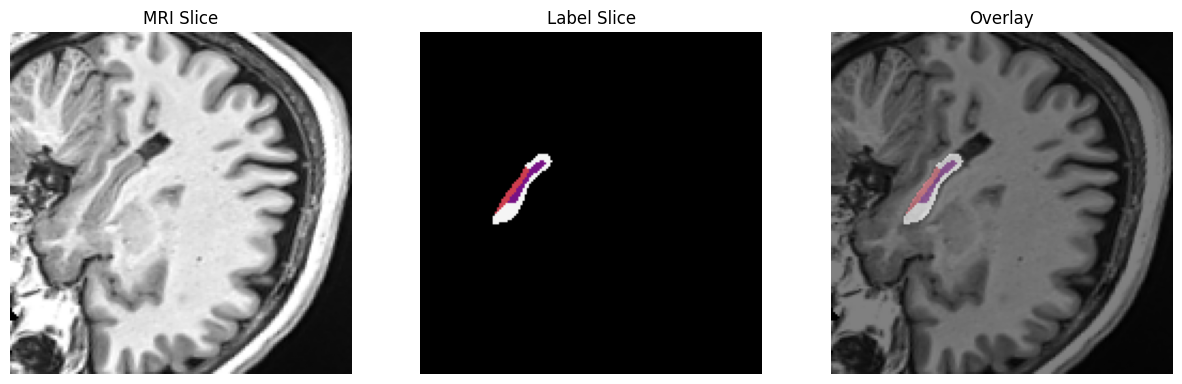

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 50, array = True)

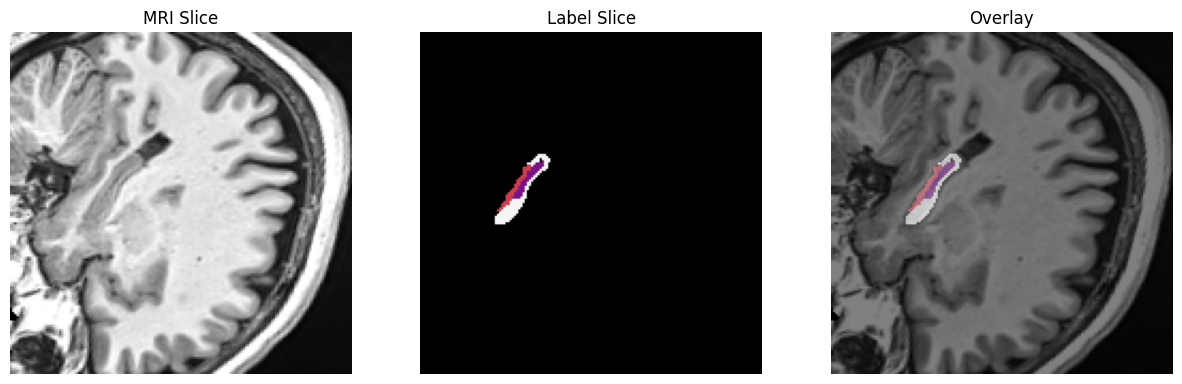

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 50, array = True)